# Tutorial: Analysis of Water Distribution Networks

## Introduction
This tutorial explores the application of `pyrocs` functions to analysis on water distribution networks. The systems that distribute drinking water (pipes, pumps, tanks, and water treatment facilities) are commonly modelled with a graph structure. This graph structure paired with detailed simulations can provide insights on various aspects of the underlying system. 

In what follows, we 1) compare two common benchmarking networks known as Net3 and Net6 using `pyrocs` metrics to hypothesize about the systems' response to a disruptive event (pipe breakage), 2) run pressure simulations of the system before and after a disruptive event, and 3) use `pyrocs` metrics to evaluate the systems' response to the disruptive event.

The Water Network Tool for Resilience (WNTR) is used to carry out the water network related analyses and must be installed prior to running the notebook. Installation instructions can be found on the [WNTR documentation](https://usepa.github.io/WNTR/installation.html).

In [23]:
import wntr
import pyrocs
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import pandas as pd

Load in water networks. Data related to each network is tracked in dictionaries.

In [24]:
Net3_dict = dict()
Net3_dict["name"] = "Net3"
Net6_dict = dict()
Net6_dict["name"] = "Net6"

In [25]:
Net3_path = "Net3.inp"
Net6_path = "Net6.inp"

Net3_dict["wn"] = wntr.network.WaterNetworkModel(Net3_path)
Net6_dict["wn"] = wntr.network.WaterNetworkModel(Net6_path)

wn_dict_list = [Net3_dict, Net6_dict]

Visualize water networks.

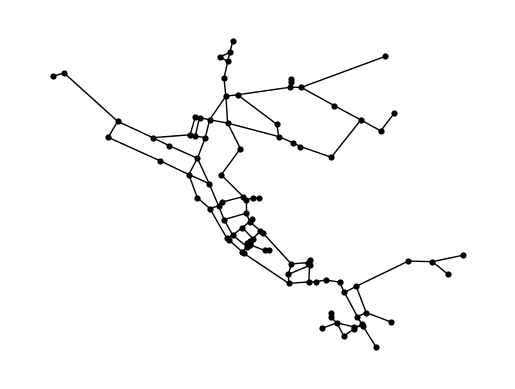

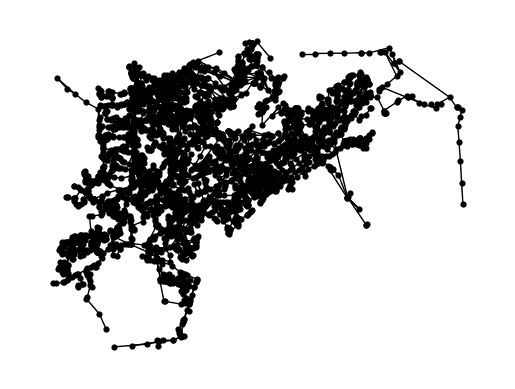

In [26]:
for wn_dict in wn_dict_list:
    wntr.graphics.plot_network(wn_dict["wn"])


Extract graph structure from water network models to run pyrocs functions.

In [27]:
for wn_dict in wn_dict_list:
    wn_dict["graph"] = nx.Graph(wn_dict["wn"].to_graph())
    wn_dict["adj_matrix"] = nx.adjacency_matrix(wn_dict["graph"])


## Use GRC to formulate hypothesis

It is common practice when studying infrastructure networks like a water distribution system to use network metrics to evaluate the resilience of the system. For this reason, we choose global reaching centrality (GRC) as a basis for a hypothesis about which network is more resilient. GRC measures the average centrality of nodes within a network, so a high GRC value means that nodes on average can reach the other nodes easily (i.e. traversing few edges) and a low GRC value means that nodes on average cannot reach other nodes easily (i.e., must traverse many edges). Having many nodes with low centrality could contribute to difficulties in maintaining pressure during a disruption. In this notebook, we consider resilience as the ability for the network to maintain normal pressure conditions in the face of a disruptive event.

This computation is timed to help quantify the computational scaling of pyrocs functions.

In [28]:
for wn_dict in wn_dict_list:
    grc_value = pyrocs.complex_systems.grc(wn_dict["adj_matrix"], directed=False)
    print(wn_dict["name"], " GRC Value: ", f"{grc_value:.4f}")


Net3  GRC Value:  0.0610
Net6  GRC Value:  0.0163


The value of GRC is much higher for Net3 than Net6 (approximately 4x). Based on this computation, we expect Net3 to have a higher level of hierarchy and therefore to have a higher resilience to disruption.

## Run Hydraulic Simulations
For each network, two scenarios for hydraulic simulation are carried out. The first is a **baseline** scenario which represents the typical functioning of the system. The second is a **disruption** scenario which represents the system's behavior in response to a disruptive event. The disruptive event chosen for this notebook is to close a pipe that connects a reservoir to the rest of the system. This effectively removes a source of water from the system, which will result in pressure loss across the system.

Run baseline hydraulics and plot resulting pressures.

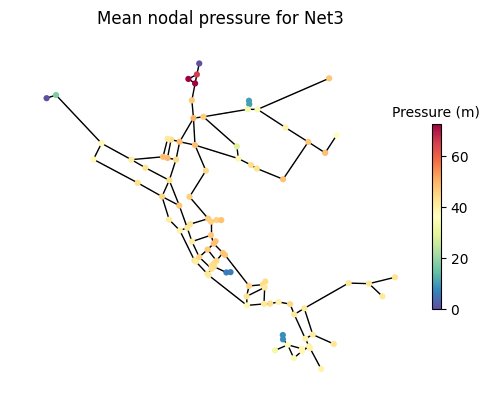

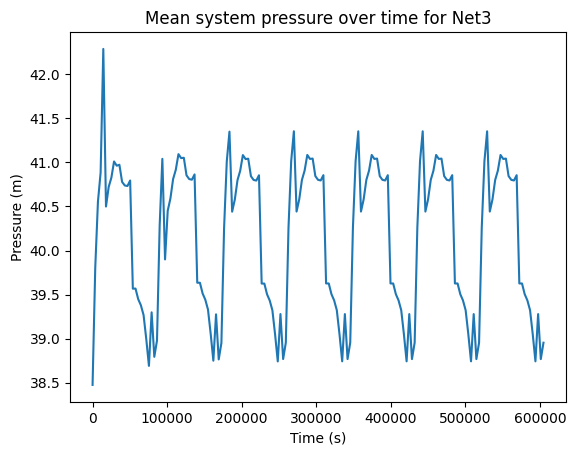

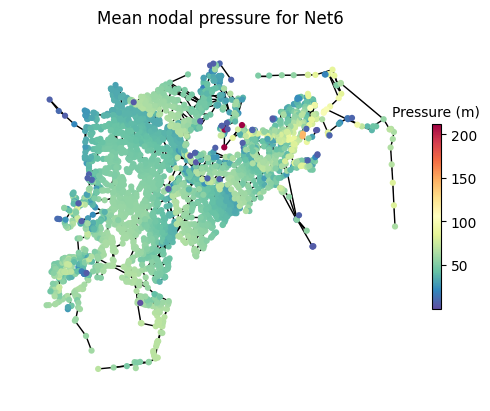

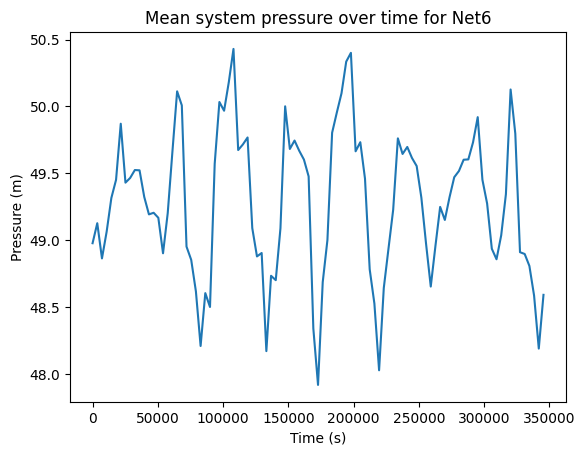

In [29]:
for wn_dict in wn_dict_list:
    sim = wntr.sim.EpanetSimulator(wn_dict["wn"])
    wn_dict["baseline_results"] = sim.run_sim()
    wn_dict["baseline_pressure"] = wn_dict["baseline_results"].node["pressure"]
    wntr.graphics.plot_network(
        wn_dict["wn"], 
        title=f"Mean nodal pressure for {wn_dict["name"]}", 
        node_colorbar_label="Pressure (m)",
        node_attribute=wn_dict["baseline_pressure"].mean(axis=0))
    
    ax = wn_dict["baseline_pressure"].mean(axis=1).plot()
    ax.set_title(f"Mean system pressure over time for {wn_dict["name"]}")
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Pressure (m)")

Networks are disrupted by closing pipe/pipes that connect the main reservoir to the network. Below we define the pipes to close for each network.

In [30]:
Net3_dict["reservoir_pipes"] = ["329", "101"]
Net6_dict["reservoir_pipes"] = ["LINK-0"]

Run the disruption scenario.

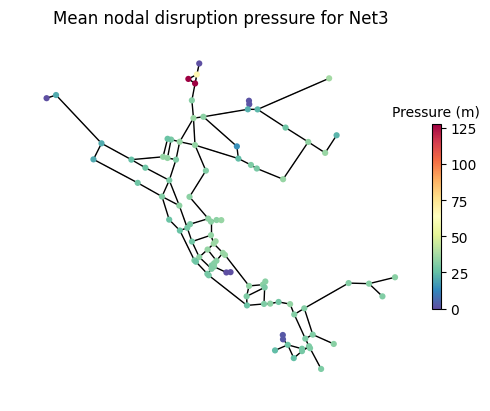

/home/klbonne/miniconda3/envs/pyrocs/lib/python3.12/site-packages/wntr/epanet/io.py:2769: UserWarning: Simulation did not converge at time 20:00:00.
  warnings.warn('Simulation did not converge at time ' + self._get_time(t) + '.')


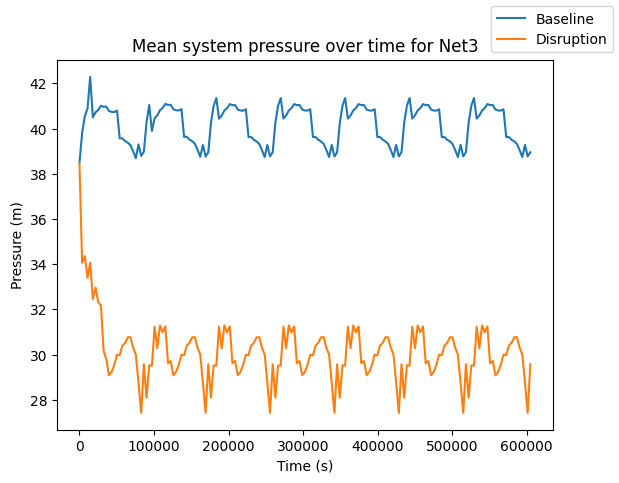

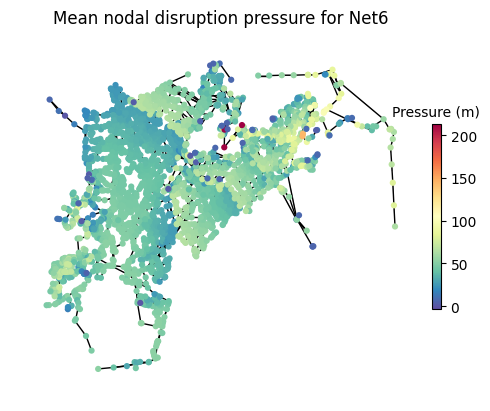

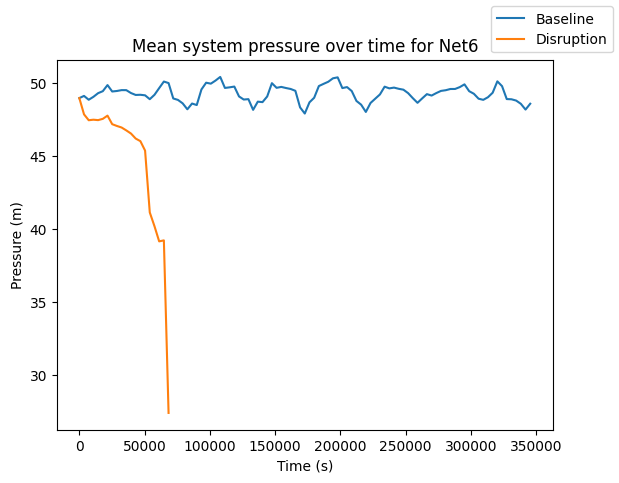

In [31]:
for wn_dict in wn_dict_list:
    wn = wn_dict["wn"]
    wn.reset_initial_values()
    
    for pipe_name in wn_dict["reservoir_pipes"]:
        pipe = wn.get_link(pipe_name)
        
        act = wntr.network.controls.ControlAction(pipe, 'status', 
                                                wntr.network.LinkStatus.Closed)
        cond = wntr.network.controls.SimTimeCondition(wn_dict["wn"], '=', '1:00:00')
        ctrl = wntr.network.controls.Control(cond, act)
        
        wn.add_control('close pipe ' + pipe_name, ctrl)
        
    sim = wntr.sim.EpanetSimulator(wn)
    wn_dict["disruption_results"] = sim.run_sim()
    wn_dict["disruption_pressure"] = wn_dict["disruption_results"].node["pressure"]
    
    for pipe_name in wn_dict["reservoir_pipes"]:
        wn.remove_control('close pipe ' + pipe_name)
    
    wntr.graphics.plot_network(
        wn_dict["wn"], 
        title=f"Mean nodal disruption pressure for {wn_dict["name"]}", 
        node_colorbar_label="Pressure (m)",
        node_attribute=wn_dict["disruption_pressure"].mean(axis=0))
    
    fig, ax = plt.subplots()
    wn_dict["baseline_pressure"].mean(axis=1).plot(ax=ax, label="Baseline")
    wn_dict["disruption_pressure"].mean(axis=1).plot(ax=ax, label="Disruption")
    ax.set_title(f"Mean system pressure over time for {wn_dict["name"]}")
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Pressure (m)")
    fig.legend()


The disruption simulation for Net6 fails after approximately 20 hours due to the lack of water availability in the system,. To account for this and allow for futher analysis, the baseline simulation is truncated to the time period that was able to be simulated for the disruption.

In [32]:
print("Number of timesteps in disruption results:", len(Net6_dict["disruption_pressure"]))
print("Number of timesteps in baseline results before processing:", len(Net6_dict["baseline_pressure"]))
Net6_dict["baseline_pressure"] = Net6_dict["baseline_pressure"].loc[wn_dict["disruption_pressure"].index]
print("Number of timesteps in baseline results after processing:", len(Net6_dict["baseline_pressure"]))


Number of timesteps in disruption results: 20
Number of timesteps in baseline results before processing: 97
Number of timesteps in baseline results after processing: 20


## Compare results using pyrocs
The output of interest from these simulations is pressure at each node across time. To quantify the resilience of each system, we use pyrocs functions to compare pressure results between the baseline and disruption scenarios.


### Compute KLD
Kullback Liebler Divergence measures the similarity between two distributions. We compare the baseline pressure distribution to the disruption pressure distribution for each network. This gives us a measurement of how much the system's behavior diverges from typical operation when the disruption occurs. The distributions to be compared are formed by looking at the normalized, mean pressure across the time steps of simulation.

Net3  KLD Value:  0.0015
Net6  KLD Value:  0.0116


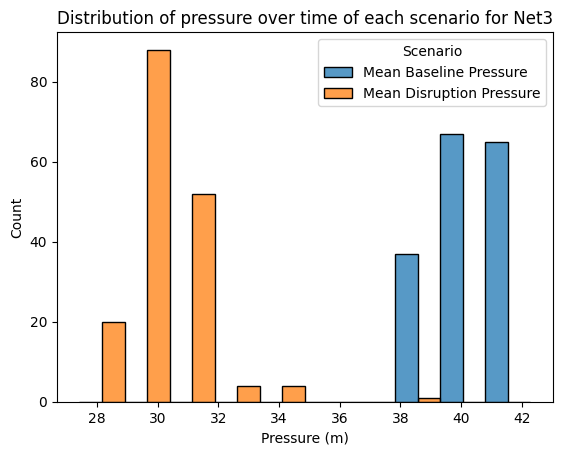

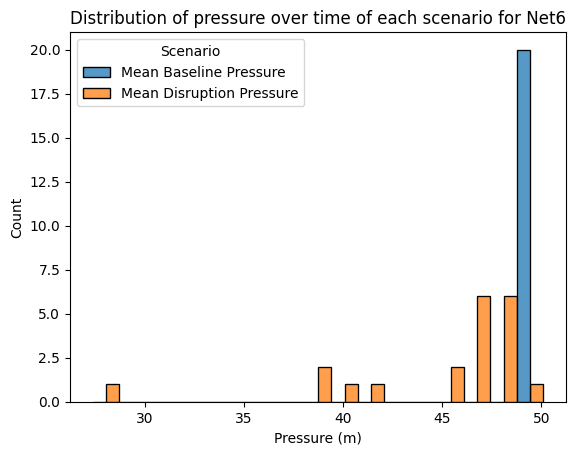

In [33]:
for wn_dict in wn_dict_list:
    fig, ax = plt.subplots()
    seaborn_df = pd.DataFrame(index=wn_dict["baseline_pressure"].index)
    seaborn_df["Mean Baseline Pressure"] = wn_dict["baseline_pressure"].mean(axis=1)
    seaborn_df["Mean Disruption Pressure"] = wn_dict["disruption_pressure"].mean(axis=1)
    seaborn_df = seaborn_df.melt()
    seaborn_df = seaborn_df.rename(columns={"variable": "Scenario", "value": "Pressure (m)"})
    sns.histplot(seaborn_df, x="Pressure (m)", hue="Scenario",multiple="dodge", ax=ax)
    ax.set_title(f"Distribution of pressure over time of each scenario for {wn_dict["name"]}")
    
    # normalize pressure
    normalized_baseline = wn_dict["baseline_pressure"].loc[wn_dict["disruption_pressure"].index].mean(axis=1) / wn_dict["baseline_pressure"].loc[wn_dict["disruption_pressure"].index].mean(axis=1).sum()
    normalized_disruption = wn_dict["disruption_pressure"].loc[wn_dict["disruption_pressure"].index].mean(axis=1) / wn_dict["disruption_pressure"].loc[wn_dict["disruption_pressure"].index].mean(axis=1).sum()
    kl_value = pyrocs.information_theory.kl_divergence(normalized_baseline, normalized_disruption)
    print(wn_dict["name"], " KLD Value: ", f"{kl_value:.4f}")


The KLD value for Net6 is approximately 0.01 and the value for Net3 is approximately 0.002, which indicates that the pressure distributions between the baseline and disruption scenarios varied more in Net6 than Net3. The histogram plots help us visualize this difference in distributions. In Net3 both scenarios have a somewhat spread out distribution of pressure and differ on average by about 10m of pressure. Net6 shows a much more dramatic difference. The baseline scenario has a very tight distribution reflecting consistent pressure throughout the entire simulation, whereas the disruption scenario varies much more. 

The results from computing KLD suggest that Net6 was impacted more by the disruption scenario than Net3, which supports the hypothesis formed based on GRC.

### Compute Mutual Information


Like KLD, MI compares two distributions, however MI helps us understand the similarity rather than difference of the distributions. We compute MI by comparing the sequences of mean pressure over time between the baseline and disruption scenarios.

In [34]:

for wn_dict in wn_dict_list:
    mi_value = pyrocs.information_theory.mutual_info(wn_dict["baseline_pressure"].mean(axis=1), wn_dict["disruption_pressure"].mean(axis=1))
    print(wn_dict["name"], " MI Value: ", f"{mi_value:.4f}")

Net3  MI Value:  4.8791
Net6  MI Value:  4.3219


While Net3 has a slightly higher MI value which means that the pressure distribution between the scenarios has more similarities in Net3 than Net6. Since the pressures are more similar, this can be interpreted as the disruptive event having a smaller effect on Net3 than Net6, which aligns with the findings from the KLD computation. 

However, despite Net3 having a higher value it is relevant to note that the value for both networks are very close in scale. It can be difficult to compare MI values because there is not an absolute scale as there is for KLD, which ranges from 0 to 1. A possible explanation for the consistent MI values across networks is that there is exists general relationship in water networks between baseline pressure in a network and the pressure of the system when the main reservoir is disconnected. 